# WG Projected Tmax

Look at the projections for $T_{max}$ evolution

In [1]:
%matplotlib inline

In [2]:
import os
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats as sstats
import datetime as dt
import sqlalchemy
import seaborn as sns
import sys

Parameters

In [3]:
START_DT = dt.datetime( 1981, 1, 1, 0, 0, 0 )
END_DT = dt.datetime( 2010, 12, 31, 0, 0, 0 )

In [4]:
SIM_IN_DIR = r'C:\Temp\WG_Test_Out\Test3\Processed'
DAY_YR = "DayYear_Stats"
SIM_DAYS = "Daily_Stats"
OUT_ROOT = "DC_WGMN3"
H0DATA_XLSX = "%s_H0Data_TMax.xlsx" % OUT_ROOT

In [5]:
OUT_DATA_DIR = r'\\augustine.space.swri.edu\jdrive\Groundwater\R8937_Stochastic_CC_Rec' \
               r'harge\Data\JNotes\Processed\PRISM\Other_Weather'

In [6]:
COMP_OUT_DIR = r'C:\Temp\WG_Test_Out\Test3\Processed\Comparison'

In [7]:
SM_NUM = 5    # start truncation; low pass of first 5 frequencies

Get our initial indexes and so forth

In [8]:
OurQs = np.array( [ round( 0.05 * x, 2 ) for x in range(21) ], dtype=np.float32 )
NumQs = len( OurQs )
NumQs

21

In [9]:
StatsHdsList = list()
for iI in range(NumQs):
    cQ = OurQs[iI]
    Hdr = "%d_ptile" % round(cQ * 100.0)
    StatsHdsList.append( Hdr )
# end of for
StatsHdsList.append( "Average" )
StatsHdsList.append( "Variance" )
StatsHdsList.append( "Skew" )
StatsHdsList.append( "Kurt" )

In [10]:
DayYrList = [x for x in range(1, 367, 1)]
DayYrIndex = np.array( DayYrList, dtype=np.int32 )

Need to access the PRISM values from the DB

In [11]:
#ExCols = [ DBAD.FIELDN_DT, DBAD.FIELDN_TMXVAL ]

In [12]:
#engine = sqlalchemy.create_engine( DBAD.DSN_STRING )
#GridSQL = DBAD.createSQLPRISMGrid()
#GridDF = pd.read_sql( GridSQL, engine, index_col=DBAD.FIELDN_ID )
# Now have the Grid that need to go through
#NumGrid = len( GridDF )
#NumGrid

In [13]:
"""
gCnt = 0
for gG in range( 1, (NumGrid + 1), 1):
    cGridID = GridDF.at[ gG, DBAD.FIELDN_GRIDIND ]
    # get our query string
    ExSQL = DBAD.createSQLPRISMTMaxSP( gG, START_DT.year, END_DT.year )
    # get the dataframe
    ValNodeDF = pd.read_sql( ExSQL, engine, columns=ExCols, parse_dates=DBAD.FIELDN_DT, 
                             index_col=DBAD.FIELDN_DT )
    if gCnt == 0:
        AllValDF = ValNodeDF.copy()
        AllValDF.columns = ["%d" % cGridID]
    else:
        ValNodeDF.columns = ["%d" % cGridID ]
        AllValDF = AllValDF.merge( ValNodeDF, how='inner', left_index=True, right_index=True )
    gCnt += 1
# end of for.
"""

'\ngCnt = 0\nfor gG in range( 1, (NumGrid + 1), 1):\n    cGridID = GridDF.at[ gG, DBAD.FIELDN_GRIDIND ]\n    # get our query string\n    ExSQL = DBAD.createSQLPRISMTMaxSP( gG, START_DT.year, END_DT.year )\n    # get the dataframe\n    ValNodeDF = pd.read_sql( ExSQL, engine, columns=ExCols, parse_dates=DBAD.FIELDN_DT, \n                             index_col=DBAD.FIELDN_DT )\n    if gCnt == 0:\n        AllValDF = ValNodeDF.copy()\n        AllValDF.columns = ["%d" % cGridID]\n    else:\n        ValNodeDF.columns = ["%d" % cGridID ]\n        AllValDF = AllValDF.merge( ValNodeDF, how=\'inner\', left_index=True, right_index=True )\n    gCnt += 1\n# end of for.\n'

At this time AllValDF should hold Tmax for every PRISM grid cell across our data period.

In [14]:
#display( HTML( AllValDF.head().to_html() ) )

In [15]:
#display( HTML( AllValDF.describe().to_html() ) )

In [16]:
"""
OutFP = os.path.normpath( os.path.join( OUT_DATA_DIR, "Tmax_DataPeriod.xlsx" ) )
with pd.ExcelWriter( OutFP, engine="openpyxl" ) as writer:
    AllValDF.to_excel( writer, sheet_name="Tmax_C", na_rep=str(np.nan) )
# end of with
"""

'\nOutFP = os.path.normpath( os.path.join( OUT_DATA_DIR, "Tmax_DataPeriod.xlsx" ) )\nwith pd.ExcelWriter( OutFP, engine="openpyxl" ) as writer:\n    AllValDF.to_excel( writer, sheet_name="Tmax_C", na_rep=str(np.nan) )\n# end of with\n'

In [17]:
#OutFP = os.path.normpath( os.path.join( OUT_DATA_DIR, "Tmax_DataPeriod.pickle" ) )
#AllValDF.to_pickle( OutFP )

In [18]:
InFP = os.path.normpath( os.path.join( OUT_DATA_DIR, "Tmax_DataPeriod.pickle" ) )
AllValDF = pd.read_pickle( InFP )

In [19]:
display( HTML( AllValDF.head().to_html() ) )

,662328,662329,662330,662331,662332,662333,662334,662335,662336,662337,662338,662339,662340,662341,662342,663733,663734,663735,663736,663737,663738,663739,663740,663741,663742,663743,663744,663745,663746,663747,665138,665139,665140,665141,665142,665143,665144,665145,665146,665147,665148,665149,665150,665151,665152,666543,666544,666545,666546,666547,666548,666549,666550,666551,666552,666553,666554,666555,666556,666557,667948,667949,667950,667951,667952,667953,667954,667955,667956,667957,667958,667959,667960,667961,667962,669353,669354,669355,669356,669357,669358,669359,669360,669361,669362,669363,669364,669365,669366,669367,670758,670759,670760,670761,670762,670763,670764,670765,670766,670767,670768,670769,670770,670771,670772,672163,672164,672165,672166,672167,672168,672169,672170,672171,672172,672173,672174,672175,672176,672177,673568,673569,673570,673571,673572,673573,673574,673575,673576,673577,673578,673579,673580,673581,673582,674973,674974,674975,674976,674977,674978,674979,674980,674981,674982,674983,674984,674985,674986,674987,676378,676379,676380,676381,676382,676383,676384,676385,676386,676387,676388,676389,676390,676391,676392,677783,677784,677785,677786,677787,677788,677789,677790,677791,677792,677793,677794,677795,677796,677797,679188,679189,679190,679191,679192,679193,679194,679195,679196,679197,679198,679199,679200,679201,679202,680593,680594,680595,680596,680597,680598,680599,680600,680601,680602,680603,680604,680605,680606,680607
Datetime_UTC,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1981-01-01 00:00:00+00:00,22.459999,22.493999,22.658001,22.732000,22.733999,22.893999,22.598000,22.379000,22.204000,22.061001,22.004999,22.007000,21.885000,21.930,22.097000,22.488001,22.580999,22.657000,22.820999,22.792000,22.962,22.572001,22.547001,22.535,22.513000,22.422001,22.278999,21.978001,22.100000,22.197001,22.702,22.707001,22.718000,22.851000,22.906000,22.858000,22.726999,22.555000,22.532000,22.437000,22.344000,22.240999,22.296000,22.318001,22.288000,22.884001,22.893000,22.987000,22.961000,22.915001,22.743000,22.648001,22.547001,22.587000,22.464001,22.309999,22.323999,22.405001,22.358000,22.139000,23.045000,23.146999,22.989000,22.882999,22.716999,22.559999,22.475000,22.399000,22.474001,22.514000,22.358000,22.499001,22.443001,22.261999,22.230000,23.091999,23.087,23.004000,22.847000,22.722000,22.701000,22.693001,22.591999,22.664000,22.538000,22.489000,22.601000,22.558001,22.412001,22.485001,23.256001,23.106001,22.924999,22.829000,22.868000,22.740999,22.830000,22.902000,22.715000,22.524000,22.646999,22.698999,22.483999,22.534000,22.502001,23.395000,23.121000,23.171000,22.962999,23.077,22.980000,22.962000,22.676001,22.735001,22.731001,22.915001,22.641001,22.514999,22.312000,22.304001,23.479000,23.509001,23.323999,23.181999,23.122999,23.406000,23.121,23.073000,22.952000,22.981001,22.816999,22.796000,22.702999,22.504999,22.292999,23.364000,23.426001,23.447001,23.361000,23.407000,23.354000,23.294001,23.304001,23.139000,22.811001,22.655001,22.664000,22.681000,22.528000,22.219000,23.247000,23.370001,23.427,23.233999,23.490999,23.503000,23.490999,23.290001,23.100000,23.122999,22.920000,22.909000,22.701000,22.479000,22.246000,23.041000,23.052999,23.122999,23.374001,23.361000,23.610001,23.429001,23.295000,23.243999,23.292000,23.254000,23.153000,22.851000,22.673000,22.486,22.812000,22.848000,23.048000,23.146999,23.393999,23.514000,23.451000,23.393000,23.330000,23.247999,23.174999,23.114000,22.941999,22.809000,22.719999,22.617001,22.781000,23.025999,23.120001,23.191000,23.243000,23.187000,23.209000,23.058001,23.035999,22.948,22.898001,22.886999,22.844,22.974001
1981-01-02 00:00:00+00:00,20.436001,20.500000,20.679001,20.770000,20.736000,20.903000,20.737000,20.562000,20.500999,20.517000,20.327999,20.242001,20.235001,20.316,20.351000,20.587000,20.726000,20.811001,20.983999,

In [20]:
AllValDF["IDayYear"] = AllValDF.index.dayofyear

In [21]:
DYList = list()
for dD in DayYrList:
    LocalList = list()
    cDyOYrDF = AllValDF[AllValDF["IDayYear"] == dD].copy()
    cDyOYrDF.drop(columns="IDayYear", inplace=True )
    npFlat = cDyOYrDF.to_numpy().flatten(order='F')
    QArray = np.quantile( npFlat, OurQs )
    LocalList.extend( QArray.tolist() )
    LocalList.append( npFlat.mean() )
    LocalList.append( npFlat.var() )
    LocalList.append( sstats.skew( npFlat ) )
    LocalList.append( sstats.kurtosis( npFlat ) )
    DYList.append( LocalList )
# end of for
DataDict = dict()
iCnt = 0
for tHdr in StatsHdsList:
    DataDict[tHdr] = np.array( [ x[iCnt] for x in DYList ], dtype=np.float32 )
    iCnt += 1
# end of for
DailyQStatsDF = pd.DataFrame( index=DayYrIndex, data=DataDict )

In [22]:
NumYears = (2010 - 1981) + 1
NumGrid = len( list( AllValDF.columns ) )
NumYears, NumGrid, NumYears * NumGrid

(30, 211, 6330)

In [23]:
display( HTML( DailyQStatsDF.head().to_html() ) )

,0_ptile,5_ptile,10_ptile,15_ptile,20_ptile,25_ptile,30_ptile,35_ptile,40_ptile,45_ptile,50_ptile,55_ptile,60_ptile,65_ptile,70_ptile,75_ptile,80_ptile,85_ptile,90_ptile,95_ptile,100_ptile,Average,Variance,Skew,Kurt
1,3.332,7.24600,10.866400,11.97250,13.607600,14.663500,15.868100,16.522650,17.084999,17.692650,18.092499,18.569450,19.120001,19.625999,20.288000,20.938499,21.562201,22.167999,22.764198,23.364149,26.895000,17.381636,23.433529,-0.745211,0.305052
2,1.876,3.89985,4.895900,5.53055,6.272800,8.420250,11.238800,13.053300,14.454801,15.301749,16.021500,16.679901,18.454802,19.661198,20.524300,20.832251,21.200201,21.632000,22.235199,23.903250,29.468000,15.021424,47.639942,-0.238573,-0.995675
3,-1.825,1.77095,5.480400,6.14900,7.408400,9.183000,10.059700,10.777950,11.906199,14.527299,15.869500,17.257700,17.908401,19.954000,20.981298,22.055500,22.566999,23.108150,23.870598,25.448000,28.403999,14.985941,57.491734,-0.266381,-0.960119
4,2.740,5.71895,7.190700,9.05970,9.765600,10.488000,11.670000,12.193899,14.021202,15.433550,16.404499,18.066351,18.432400,18.867001,19.275299,20.205000,21.110601,21.945999,25.675697,27.299398,29.774000,15.977472,42.108105,0.112813,-0.776396
5,3.657,7.88930,9.519501,10.11555,10.788799,13.039249,13.885201,14.544650,15.413000,16.332100,16.931000,17.380899,17.761999,18.141048,18.963598,19.781500,20.289200,20.631151,21.136099,21.998098,25.896000,15.937245,21.359106,-0.500546,-0.476008


Now load the simulation results

In [24]:
IN_XLSX = os.path.normpath( os.path.join( SIM_IN_DIR, H0DATA_XLSX))
SimH0 = pd.read_excel( IN_XLSX, sheet_name=DAY_YR, header=0, index_col=0 )

In [25]:
display( HTML( SimH0.head().to_html() ) )

,0_ptile,5_ptile,10_ptile,15_ptile,20_ptile,25_ptile,30_ptile,35_ptile,40_ptile,45_ptile,50_ptile,55_ptile,60_ptile,65_ptile,70_ptile,75_ptile,80_ptile,85_ptile,90_ptile,95_ptile,100_ptile,Average,Variance,Skew,Kurt
1,-10.268376,-0.113728,2.742485,4.679821,6.208668,7.512201,8.696443,9.771842,10.807323,11.802902,12.782940,13.781673,14.778994,15.806273,16.885284,18.064297,19.366667,20.906908,22.829842,25.695133,38.921234,12.792747,60.978180,0.006325,-0.087486
2,-10.300507,-0.118916,2.669088,4.577512,6.114398,7.425786,8.598435,9.689987,10.729423,11.730433,12.706604,13.688638,14.688041,15.724788,16.811140,17.984951,19.292576,20.834265,22.777723,25.663141,38.969025,12.718971,61.061523,0.017244,-0.088726
3,-10.327695,-0.209815,2.622948,4.510626,6.036545,7.346157,8.510635,9.596886,10.627629,11.632524,12.626524,13.605678,14.613190,15.638262,16.732428,17.909769,19.221384,20.767111,22.719746,25.625137,39.018009,12.649329,61.219940,0.027622,-0.082641
4,-10.349759,-0.248533,2.587509,4.474628,5.989679,7.298026,8.463401,9.550798,10.572497,11.576774,12.563906,13.552629,14.559046,15.596534,16.697643,17.868649,19.190674,20.730803,22.671019,25.599319,39.068123,12.604431,61.155762,0.029447,-0.084885
5,-10.366528,-0.282413,2.499430,4.429140,5.958936,7.257761,8.434763,9.527908,10.571069,11.568981,12.552670,13.541079,14.537642,15.586396,16.686546,17.860596,19.157164,20.694235,22.663424,25.590235,39.119347,12.581042,61.334560,0.029160,-0.090084


In [26]:
for iI in range(len(StatsHdsList)):
    print("%d : %s" % (iI, StatsHdsList[iI]))
# end for

0 : 0_ptile
1 : 5_ptile
2 : 10_ptile
3 : 15_ptile
4 : 20_ptile
5 : 25_ptile
6 : 30_ptile
7 : 35_ptile
8 : 40_ptile
9 : 45_ptile
10 : 50_ptile
11 : 55_ptile
12 : 60_ptile
13 : 65_ptile
14 : 70_ptile
15 : 75_ptile
16 : 80_ptile
17 : 85_ptile
18 : 90_ptile
19 : 95_ptile
20 : 100_ptile
21 : Average
22 : Variance
23 : Skew
24 : Kurt


Make a probabilistic time history style plot

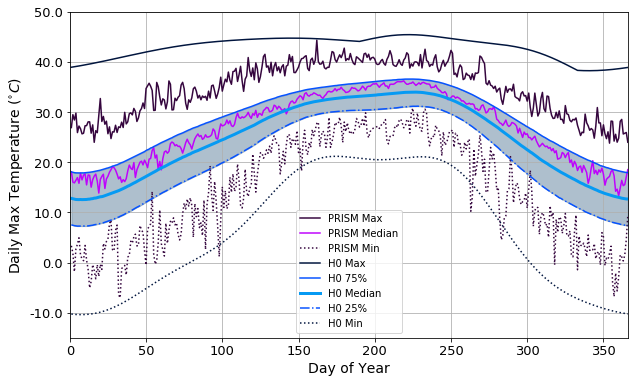

In [27]:
Fig1 = plt.figure()
Fig1.set_size_inches(10.0, 6.0)
ax11 = Fig1.add_subplot(111)
ax11.plot( DailyQStatsDF.index, DailyQStatsDF[StatsHdsList[20]], color="xkcd:dark purple", 
           linestyle="-", label="PRISM Max")
ax11.plot( DailyQStatsDF.index, DailyQStatsDF[StatsHdsList[10]], color="xkcd:bright purple", 
           linestyle="-", label="PRISM Median")
ax11.plot( DailyQStatsDF.index, DailyQStatsDF[StatsHdsList[0]], color="xkcd:dark purple", 
           linestyle=":", label="PRISM Min")
ax11.plot( SimH0.index, SimH0[StatsHdsList[20]], color="xkcd:navy", linestyle="-", 
           label="H0 Max")
ax11.plot( SimH0.index, SimH0[StatsHdsList[15]], color="xkcd:electric blue", linestyle="-", 
           label="H0 75%")
ax11.plot( SimH0.index, SimH0[StatsHdsList[10]], color="xkcd:azure", linestyle="-", 
           linewidth=3, label="H0 Median")
ax11.plot( SimH0.index, SimH0[StatsHdsList[5]], color="xkcd:electric blue", linestyle="-.", 
           label="H0 25%")
ax11.plot( SimH0.index, SimH0[StatsHdsList[0]], color="xkcd:navy", linestyle=":", 
           label="H0 Min")
ax11.fill_between( SimH0.index, SimH0[StatsHdsList[5]], SimH0[StatsHdsList[15]],
                   color='xkcd:greyish blue', alpha=0.5 )
ax11.set_xlabel('Day of Year', fontsize=14 )
ax11.set_ylabel('Daily Max Temperature $( ^{\circ} C)$', fontsize=14)
ax11.set_xlim( (0.0, 366.0) )
ax11.set_ylim( (-15.0, 50.0) )
ax11.grid( b=True )
ax11.legend(loc='lower center')
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )

Now use pairplot to compare all four moments

In [28]:
CompMomentsDF = DailyQStatsDF[[StatsHdsList[21], StatsHdsList[22], StatsHdsList[23], StatsHdsList[24]]].copy()
CompMomentsDF.columns = ["PRISM Mean", "PRISM Variance", "PRISM Skewness", "PRISM Kurtosis"]

In [29]:
CompMomentsDF["WG H0 Mean"] = SimH0[StatsHdsList[21]]
CompMomentsDF["WG H0 Variance"] = SimH0[StatsHdsList[22]]
CompMomentsDF["WG H0 Skewness"] = SimH0[StatsHdsList[23]]
CompMomentsDF["WG H0 Kurtosis"] = SimH0[StatsHdsList[24]]

In [30]:
sns.set(style="ticks", color_codes=True)

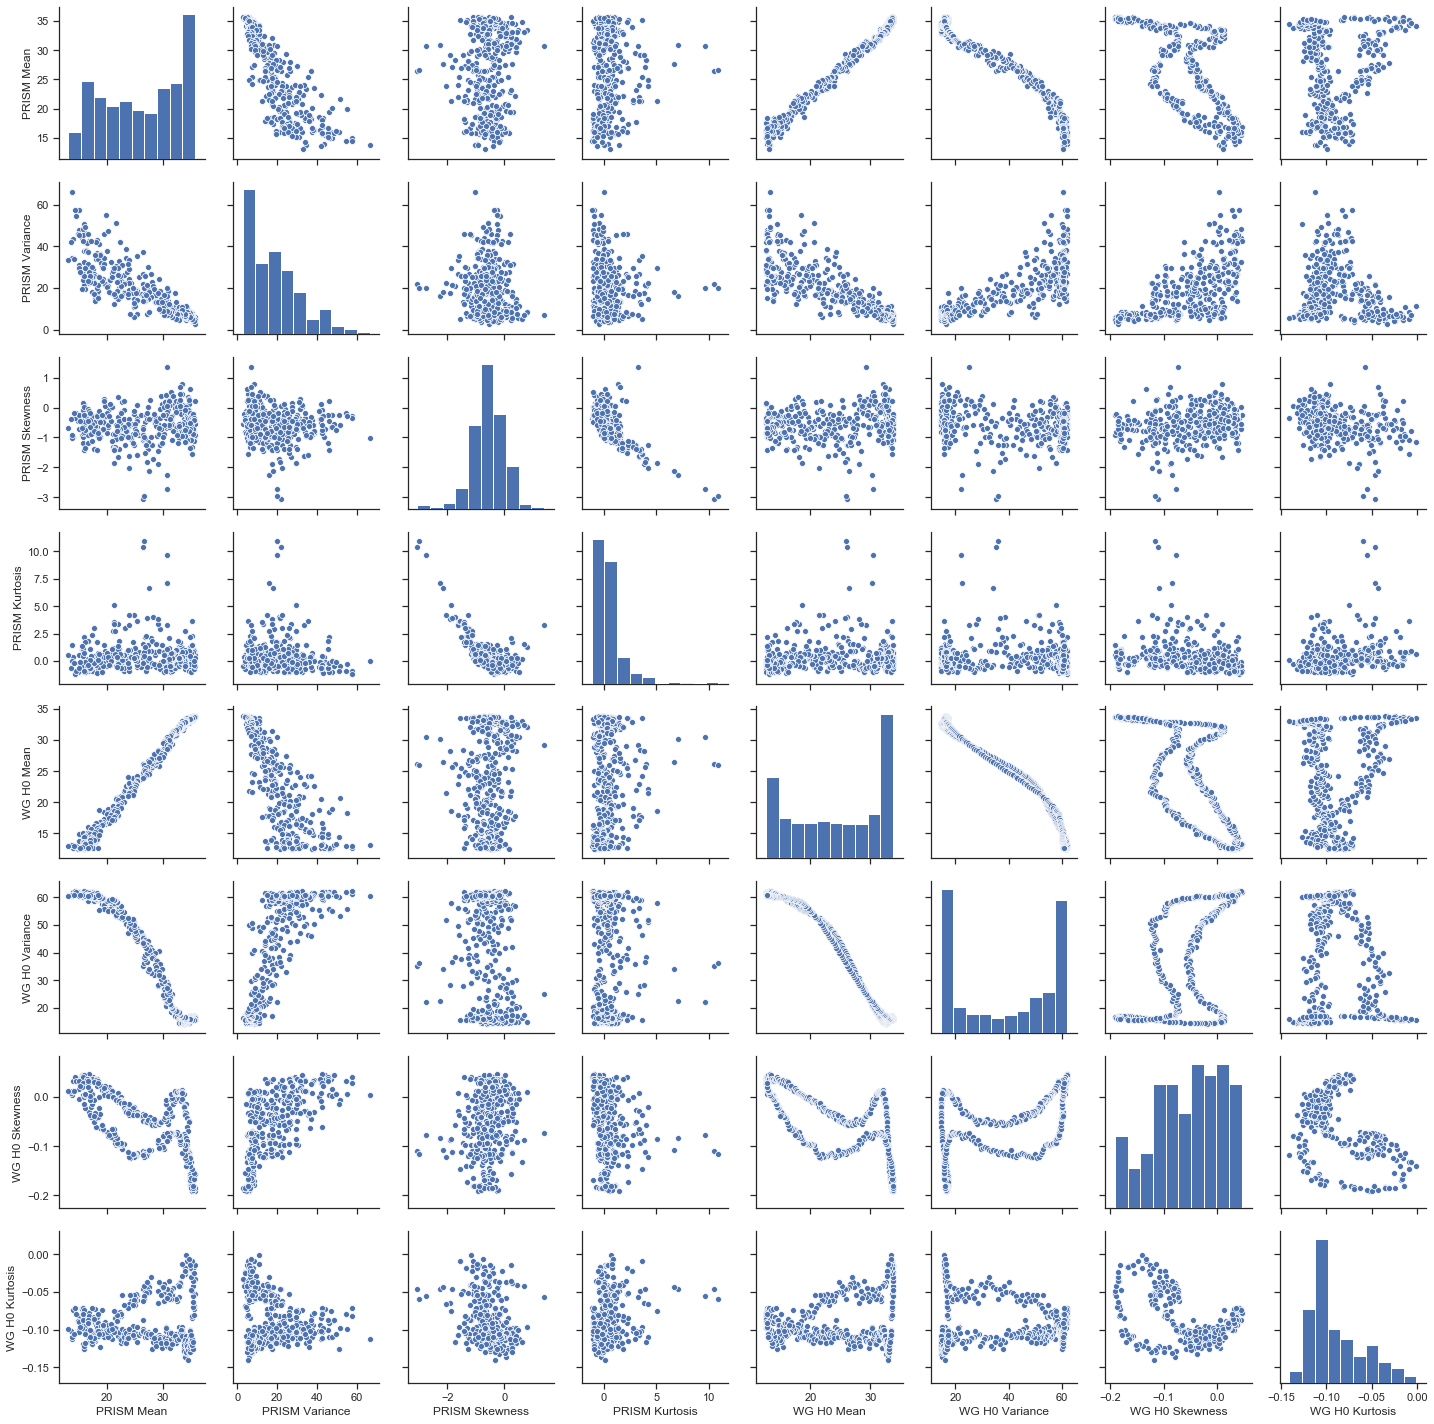

In [31]:
g = sns.pairplot(CompMomentsDF)

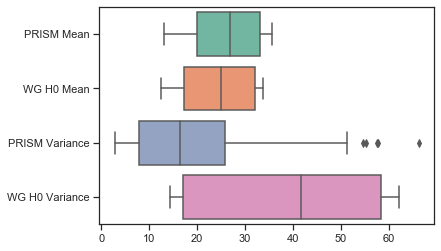

In [32]:
ax = sns.boxplot( data=CompMomentsDF[["PRISM Mean", "WG H0 Mean", "PRISM Variance", "WG H0 Variance"]], 
                  orient="h", palette="Set2")

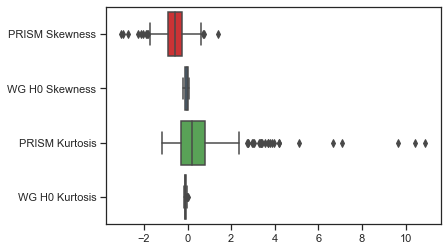

In [33]:
ax = sns.boxplot( data=CompMomentsDF[["PRISM Skewness", "WG H0 Skewness", "PRISM Kurtosis", "WG H0 Kurtosis"]], 
                  orient="h", palette="Set1")

In [34]:
OutFP = os.path.normpath( os.path.join( COMP_OUT_DIR, "Tmax_DataP_DayofYear.pickle" ) )
DailyQStatsDF.to_pickle( OutFP )

In [35]:
display( HTML( CompMomentsDF.head().to_html() ) )

,PRISM Mean,PRISM Variance,PRISM Skewness,PRISM Kurtosis,WG H0 Mean,WG H0 Variance,WG H0 Skewness,WG H0 Kurtosis
1,17.381636,23.433529,-0.745211,0.305052,12.792747,60.978180,0.006325,-0.087486
2,15.021424,47.639942,-0.238573,-0.995675,12.718971,61.061523,0.017244,-0.088726
3,14.985941,57.491734,-0.266381,-0.960119,12.649329,61.219940,0.027622,-0.082641
4,15.977472,42.108105,0.112813,-0.776396,12.604431,61.155762,0.029447,-0.084885
5,15.937245,21.359106,-0.500546,-0.476008,12.581042,61.334560,0.029160,-0.090084


Now make a final output spreadsheet

In [36]:
OutFiler = os.path.normpath( os.path.join( COMP_OUT_DIR, "%s_PRISM_H0_Tmax_Comp.xlsx" % OUT_ROOT ) )
with pd.ExcelWriter( OutFiler ) as writer:
    CompMomentsDF.to_excel( writer, sheet_name="Compare", index_label="DayOfYear", na_rep=str(np.nan) )
    DailyQStatsDF.to_excel( writer, sheet_name="PRISM", columns=StatsHdsList, 
                            index_label="DayOfYear", na_rep=str(np.nan) )
    SimH0.to_excel( writer, sheet_name="H0", columns=StatsHdsList, 
                    index_label="DayOfYear", na_rep=str(np.nan) )

## Look at Fourier Smoothing

In [37]:
PickIn = os.path.normpath( os.path.join( r'\\augustine.space.swri.edu\jdrive\Groundwat' \
                                         r'er\R8937_Stochastic_CC_Recharge\Data\JN' \
                                         r'otes\Processed\PRISM\Other_Weather', 
                                         "OWeath_Wet_Smooth_Ave_1981-2010.pickle" ) )
InWetDF = pd.read_pickle( PickIn )
PickIn = os.path.normpath( os.path.join( r'\\augustine.space.swri.edu\jdrive\Groundwat' \
                                         r'er\R8937_Stochastic_CC_Recharge\Data\JN' \
                                         r'otes\Processed\PRISM\Other_Weather', 
                                         "OWeath_Dry_Smooth_Ave_1981-2010.pickle" ) )
InDryDF = pd.read_pickle( PickIn )

In [38]:
display( HTML( InWetDF.head().to_html() ) )

,Tmax_C,Tmean_C,Tmin_C,DewPtT_C,RelHum
1,12.004342,7.542461,3.081444,2.937763,73.832413
2,11.968456,7.516122,3.064638,2.908288,73.821342
3,11.937980,7.494088,3.051048,2.883328,73.812378
4,11.913011,7.476401,3.040646,2.862903,73.805328
5,11.893646,7.463113,3.033433,2.847029,73.800041


In [39]:
Tmax = np.array( SimH0[StatsHdsList[21]], dtype=np.float32 )

In [40]:
rft = np.fft.rfft(Tmax)
rft[SM_NUM:] = 0.0
tmax_smooth = np.fft.irfft(rft)

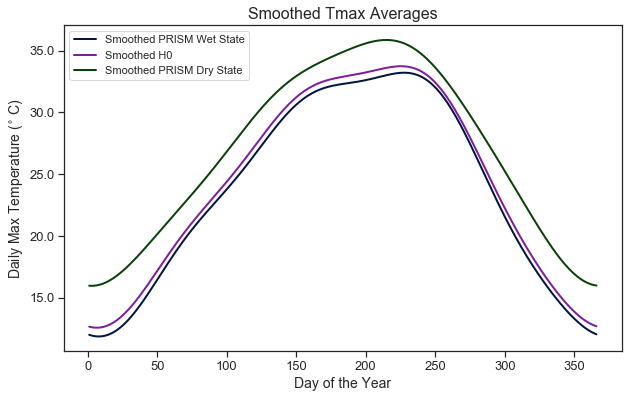

In [41]:
Fig1 = plt.figure()
Fig1.set_size_inches(10.0, 6.0)
ax11 = Fig1.add_subplot(111)
ax11.plot( DayYrIndex, InWetDF['Tmax_C'], linestyle='-', color='xkcd:navy', linewidth=2.0, 
           label="Smoothed PRISM Wet State")
ax11.plot( DayYrIndex, tmax_smooth, linestyle='-', color='xkcd:purple', linewidth=2.0, 
           label="Smoothed H0")
ax11.plot( DayYrIndex, InDryDF['Tmax_C'], linestyle='-', color='xkcd:hunter green', linewidth=2.0, 
           label="Smoothed PRISM Dry State")
ax11.set_title('Smoothed Tmax Averages', fontsize=16 )
ax11.set_xlabel('Day of the Year', fontsize=14 )
ax11.set_ylabel('Daily Max Temperature ($^{\circ}$ C)', fontsize=14)
ax11.legend()
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )